In [1]:
# imports
import snntorch as snn
from snntorch import spikeplot as splt
from snntorch import spikegen

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

import matplotlib.pyplot as plt
import numpy as np
import itertools

In [2]:
class vortex_lif(nn.Module):
    def __init__(self, beta = 0.09, threshold=0.9, alpha=1, gamma = 50):
        """
        Initialize the Vortex LIF model with given parameters.

        Parameters:
        beta (float): Decay rate of the magnetic vortex.
        threshold (float): Threshold for spike generation.
        alpha (float): Constant affecting input current scaling.
        gamma (float): Constant affecting the vortex dynamics after spike happens.
        """
        super(vortex_lif, self).__init__()

        self.beta = beta
        self.alpha = alpha
        self.threshold = threshold
        self.gamma = gamma


        # Initialize a tensor to keep track of the trigger after a spike and mem reach till 0.1
        self.trigger_tensor = None

        self.spike_gradient = self.ATan.apply

    def forward(self, input_, mem):
        """
        Forward pass for the Vortex LIF neuron.

        Parameters:
        input_ (torch.Tensor): Input current.
        mem (torch.Tensor): Membrane potential.

        Returns:
        spk (torch.Tensor): Spike output.
        mem (torch.Tensor): Updated membrane potential.
        """
        input_ = torch.relu(input_)

        dt = 1  # Time step for the simulation

        # Calculate spikes using the custom gradient function
        spk = self.spike_gradient(mem)

        # Initialize decay timer if not already initialized
        if self.trigger_tensor is None:
            self.trigger_tensor = torch.zeros_like(mem)



        trigger = torch.ones_like(mem)  
        
        # Update trigger tensor: zero where no spike and one where spike
        self.trigger_tensor = torch.where(spk > 0, trigger, self.trigger_tensor)


        # dummy tensor to keep track updated mem due to spike based trigger
        updated_mem_due_to_trigger = torch.where(self.trigger_tensor > 0, torch.max(0.1 * torch.ones_like(mem), mem - mem * self.gamma * input_ * dt), torch.zeros_like(mem))


        # Update the membrane potential based on vortex dynamicsDecrease the triggered otherwise increase
        mem = torch.where(self.trigger_tensor > 0, torch.max(0.1 * torch.ones_like(mem), (mem - mem * self.gamma * input_ * dt).detach()), mem + mem * (input_ * self.alpha - self.beta) * dt)


        # Keep the trigger on if dummy > 0.1, otherwise turn it off
        self.trigger_tensor = torch.where(updated_mem_due_to_trigger > 0.1, self.trigger_tensor, torch.zeros_like(self.trigger_tensor))

        return spk, mem

    @staticmethod
    class ATan(torch.autograd.Function):
        @staticmethod
        def forward(ctx, mem):
            """
            Forward pass for the custom spike gradient.

            Parameters:
            ctx: Context object to store information for backward computation.
            mem (torch.Tensor): Membrane potential.

            Returns:
            spk (torch.Tensor): Spike output using a Heaviside step function.
            """
            spk = ((mem - 0.9) > 0).float()  # Heaviside on the forward pass
            ctx.save_for_backward(mem)  # store the membrane for use in the backward pass
            return spk

        @staticmethod
        def backward(ctx, grad_output):
            """
            Backward pass for the custom spike gradient.

            Parameters:
            ctx: Context object containing saved tensors.
            grad_output (torch.Tensor): Gradient of the loss w.r.t. output.

            Returns:
            grad (torch.Tensor): Gradient of the loss w.r.t. input.
            """
            (mem,) = ctx.saved_tensors  # retrieve the membrane potential

            # Compute the gradient using an arctangent approximation
            grad = 1 / (1 + (torch.pi * (mem - 0.9)).pow_(2)) * grad_output * mem
            return grad

In [3]:
# class vortex_lif(nn.Module):
#     def __init__(self, beta, threshold=0.9, alpha=1, decay_factor=0.5):
#         """
#         Initialize the Vortex LIF model with given parameters.

#         Parameters:
#         beta (float): Decay rate of the magnetic vortex.
#         threshold (float): Threshold for spike generation.
#         alpha (float): Constant affecting input current scaling.
#         decay_factor (float): Exponential decay factor applied after a spike.
#         decay_steps (int): Number of steps to apply the exponential decay after a spike.
#         """
#         super(vortex_lif, self).__init__()

#         self.beta = beta
#         self.alpha = alpha
#         self.threshold = threshold
#         self.decay_factor = decay_factor


#         # Initialize a tensor to keep track of decay steps after a spike
#         self.decay_timer = None

#         self.spike_gradient = self.ATan.apply

#     def forward(self, input_, mem):
#         """
#         Forward pass for the Vortex LIF neuron.

#         Parameters:
#         input_ (torch.Tensor): Input current.
#         mem (torch.Tensor): Membrane potential.

#         Returns:
#         spk (torch.Tensor): Spike output.
#         mem (torch.Tensor): Updated membrane potential.
#         """
#         input_ = torch.relu(input_)

#         dt = 1  # Time step for the simulation

#         # Calculate spikes using the custom gradient function
#         spk = self.spike_gradient(mem)

#         # Initialize decay timer if not already initialized
#         if self.decay_timer is None:
#             self.decay_timer = torch.zeros_like(mem)


#         # Calculate decay steps based on input
#         decay_steps = torch.clamp(input_.int(), min=1)  # Ensure at least 1 step
        
#         # Update decay timer: increment where no spike, reset to decay_steps where spike
#         self.decay_timer = torch.where(spk > 0, decay_steps, torch.max(self.decay_timer - 1, torch.zeros_like(self.decay_timer)))

        
#         mem_update_term = torch.where(self.decay_timer > 0, self.decay_factor * input_ * mem, mem * (input_ * self.alpha - self.beta) * dt)

#         # reset = (decay * input_).detach() # remove reset from computational graph

#         # Update the membrane potential based on vortex dynamics
#         mem = mem + mem_update_term

#         return spk, mem

#     @staticmethod
#     class ATan(torch.autograd.Function):
#         @staticmethod
#         def forward(ctx, mem):
#             """
#             Forward pass for the custom spike gradient.

#             Parameters:
#             ctx: Context object to store information for backward computation.
#             mem (torch.Tensor): Membrane potential.

#             Returns:
#             spk (torch.Tensor): Spike output using a Heaviside step function.
#             """
#             spk = ((mem - 0.9) > 0).float()  # Heaviside on the forward pass
#             ctx.save_for_backward(mem)  # store the membrane for use in the backward pass
#             return spk

#         @staticmethod
#         def backward(ctx, grad_output):
#             """
#             Backward pass for the custom spike gradient.

#             Parameters:
#             ctx: Context object containing saved tensors.
#             grad_output (torch.Tensor): Gradient of the loss w.r.t. output.

#             Returns:
#             grad (torch.Tensor): Gradient of the loss w.r.t. input.
#             """
#             (mem,) = ctx.saved_tensors  # retrieve the membrane potential

#             # Compute the gradient using an arctangent approximation
#             grad = 1 / (1 + (torch.pi * (mem - 0.9)).pow_(2)) * grad_output * mem
#             return grad

# 5. Setting up the Static MNIST Dataset

In [4]:
# dataloader arguments
batch_size = 128
data_path='/tmp/data/mnist'

dtype = torch.float
device = torch.device("cpu") #if torch.cuda.is_available() else torch.device("cpu")

In [5]:
# Define a transform
transform = transforms.Compose([
            transforms.Resize((28, 28)),
            transforms.Grayscale(),
            transforms.ToTensor(),
            transforms.Normalize((0,), (1,))])

mnist_train = datasets.MNIST(data_path, train=True, download=True, transform=transform)
mnist_test = datasets.MNIST(data_path, train=False, download=True, transform=transform)

In [6]:
# Create DataLoaders
train_loader = DataLoader(mnist_train, batch_size=batch_size, shuffle=True, drop_last=True)
test_loader = DataLoader(mnist_test, batch_size=batch_size, shuffle=True, drop_last=True)

In [7]:
# Network Architecture
num_inputs = 28*28
num_hidden = 2000
num_outputs = 10

# Temporal Dynamics
num_steps = 25
beta = 0.09

In [8]:
# Define Network
class Net(nn.Module):
    def __init__(self):
        super().__init__()

        # Initialize layers
        self.fc1 = nn.Linear(num_inputs, num_hidden)
        self.lif1 = vortex_lif(beta=beta)
        self.fc2 = nn.Linear(num_hidden, num_outputs)
        self.lif2 = vortex_lif(beta=beta)

    def forward(self, x):

        # Initialize hidden states at t=0
        mem1 = torch.rand(x.size(0), num_hidden, dtype=torch.float32)  
        mem2 = torch.rand(x.size(0), num_outputs, dtype=torch.float32)


        # Record the final layer

        spk2_rec, mem2_rec, cur1_rec, cur2_rec, spk1_rec, mem1_rec = [], [], [], [], [], []

        for step in range(num_steps):
            cur1 = self.fc1(x)
            spk1, mem1 = self.lif1(cur1, mem1)
            cur2 = self.fc2(spk1)
            spk2, mem2 = self.lif2(cur2, mem2)
            cur1_rec.append(cur1)  # Record current for layer 1
            spk1_rec.append(spk1)
            mem1_rec.append(mem1)
            spk2_rec.append(spk2)
            mem2_rec.append(mem2)
            cur2_rec.append(cur2)  # Record current for layer 2

        return torch.stack(cur1_rec, dim=0), torch.stack(cur2_rec, dim=0), torch.stack(spk1_rec, dim=0), torch.stack(mem1_rec, dim=0), torch.stack(spk2_rec, dim=0), torch.stack(mem2_rec, dim=0)


# Load the network onto CUDA if available
net = Net().to(device)

In [9]:
# pass data into the network, sum the spikes over time
# and compare the neuron with the highest number of spikes
# with the target

def print_batch_accuracy(data, targets, train=False):
    output = net(data.view(batch_size, -1))
    output = output[4]
    _, idx = output.sum(dim=0).max(1)
    acc = np.mean((targets == idx).detach().cpu().numpy())

    if train:
        print(f"Train set accuracy for a single minibatch: {acc*100:.2f}%")
    else:
        print(f"Test set accuracy for a single minibatch: {acc*100:.2f}%")

def train_printer(
    data, targets, epoch,
    counter, iter_counter,
        loss_hist, test_loss_hist, test_data, test_targets):
    print(f"Epoch {epoch}, Iteration {iter_counter}")
    print(f"Train Set Loss: {loss_hist[counter]:.2f}")
    print(f"Test Set Loss: {test_loss_hist[counter]:.2f}")
    print_batch_accuracy(data, targets, train=True)
    print_batch_accuracy(test_data, test_targets, train=False)
    print("\n")

In [10]:
loss = nn.CrossEntropyLoss()

In [11]:
optimizer = torch.optim.Adam(net.parameters(), lr=3e-4, betas=(0.9, 0.999))

In [12]:
data, targets = next(iter(train_loader))
data = data.to(device)
targets = targets.to(device)

In [13]:
cur1, cur2, spk1_rec, mem1_rec, spk2_rec, mem2_rec = net(data.view(batch_size, -1))
print(mem2_rec.size())

torch.Size([25, 128, 10])


In [14]:
# initialize the total loss value
loss_val = torch.zeros((1), dtype=dtype, device=device)

# sum loss at every step
for step in range(num_steps):
  loss_val += loss(spk2_rec[step], targets)

print(f"Training loss: {loss_val.item():.3f}")

Training loss: 57.988


In [15]:
print_batch_accuracy(data, targets, train=True)

Train set accuracy for a single minibatch: 14.06%


In [16]:
# clear previously stored gradients
optimizer.zero_grad()

# calculate the gradients
loss_val.backward()

# weight update
optimizer.step()

In [17]:
# calculate new network outputs using the same data
cur1, cur2, spk1_rec, mem1_rec, spk2_rec, mem2_rec = net(data.view(batch_size, -1))

# initialize the total loss value
loss_val = torch.zeros((1), dtype=dtype, device=device)

# sum loss at every step
for step in range(num_steps):
  loss_val += loss(spk2_rec[step], targets)

print(f"Training loss: {loss_val.item():.3f}")
print_batch_accuracy(data, targets, train=True)

Training loss: 58.014
Train set accuracy for a single minibatch: 12.50%


In [18]:
num_epochs = 1
loss_hist = []
test_loss_hist = []
counter = 0

# Outer training loop
for epoch in range(num_epochs):
    iter_counter = 0
    train_batch = iter(train_loader)

    # Minibatch training loop
    for data, targets in train_batch:
        data = data.to(device)
        targets = targets.to(device)

        # forward pass
        net.train()
        cur1, cur2, spk1_rec, mem1_rec, spk2_rec, mem2_rec = net(data.view(batch_size, -1))

        # initialize the loss & sum over time
        loss_val = torch.zeros((1), dtype=dtype, device=device)
        for step in range(num_steps):
            loss_val += loss(spk2_rec[step], targets)

        # Gradient calculation + weight update
        optimizer.zero_grad()
        loss_val.backward()
        optimizer.step()

        # Store loss history for future plotting
        loss_hist.append(loss_val.item())

        # Test set
        with torch.no_grad():
            net.eval()
            test_data, test_targets = next(iter(test_loader))
            test_data = test_data.to(device)
            test_targets = test_targets.to(device)

            # Test set forward pass
            test_cur1, test_cur2, test_spk1_rec, test_mem1_rec, test_spk2_rec, test_mem2_rec = net(test_data.view(batch_size, -1))

            # Test set loss
            test_loss = torch.zeros((1), dtype=dtype, device=device)
            for step in range(num_steps):
                test_loss += loss(test_spk2_rec[step], test_targets)
            test_loss_hist.append(test_loss.item())

            # Print train/test loss/accuracy
            if counter % 50 == 0:
                train_printer(
                    data, targets, epoch,
                    counter, iter_counter,
                    loss_hist, test_loss_hist,
                    test_data, test_targets)
            counter += 1
            iter_counter +=1

Epoch 0, Iteration 0
Train Set Loss: 58.15
Test Set Loss: 58.15
Train set accuracy for a single minibatch: 17.19%
Test set accuracy for a single minibatch: 9.38%


Epoch 0, Iteration 50
Train Set Loss: 57.40
Test Set Loss: 56.76
Train set accuracy for a single minibatch: 27.34%
Test set accuracy for a single minibatch: 33.59%


Epoch 0, Iteration 100
Train Set Loss: 57.89
Test Set Loss: 57.00
Train set accuracy for a single minibatch: 26.56%
Test set accuracy for a single minibatch: 26.56%




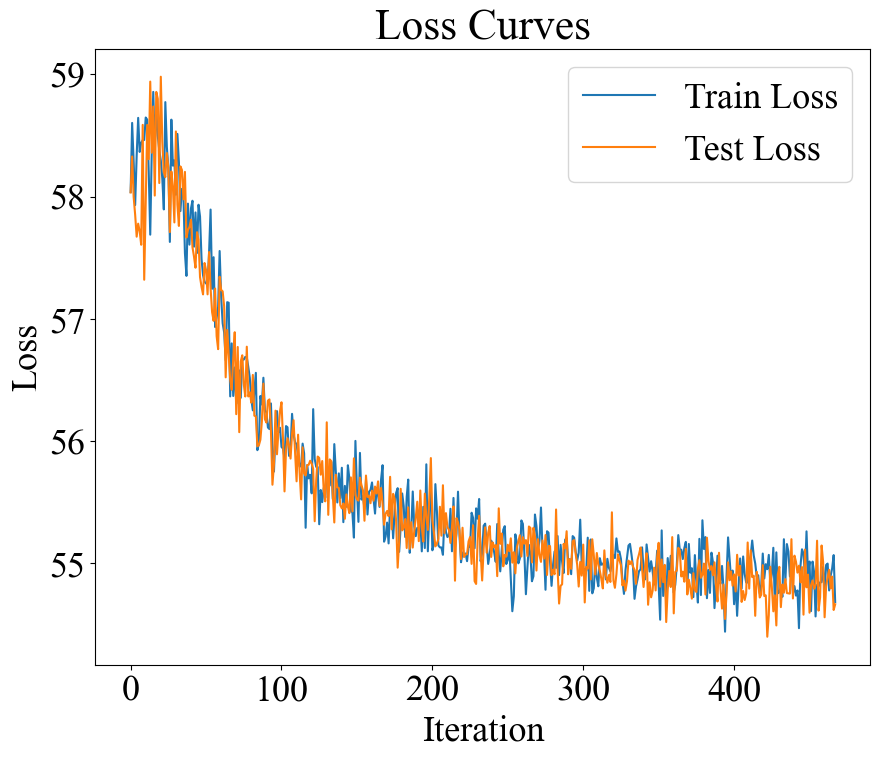

In [ ]:
# Plot Loss
plt.rcParams.update({'font.size': 26, 'font.family': 'Times New Roman'})
fig = plt.figure(facecolor="w", figsize=(10, 8))
plt.plot(loss_hist)
plt.plot(test_loss_hist)
plt.title("Loss Curves")
plt.legend(["Train Loss", "Test Loss"])
plt.xlabel("Iteration")
plt.ylabel("Loss")
# plt.ylim(0,1000)
plt.show()

In [ ]:
# total = 0
# correct = 0

# # drop_last switched to False to keep all samples
# test_loader = DataLoader(mnist_test, batch_size=batch_size, shuffle=True, drop_last=False)

# with torch.no_grad():
#   net.eval()
#   for data, targets in test_loader:
#     data = data.to(device)
#     targets = targets.to(device)

#     # forward pass
#     output = net(data.view(data.size(0), -1))
     
#     test_spk = output[4]
#     # calculate total accuracy
#     _, predicted = test_spk.sum(dim=0).max(1)
#     total += targets.size(0)
#     correct += (predicted == targets).sum().item()

# print(f"Total correctly classified test set images: {correct}/{total}")
# print(f"Test Set Accuracy: {100 * correct / total:.2f}%")

RuntimeError: The size of tensor a (16) must match the size of tensor b (128) at non-singleton dimension 0

In [ ]:
# # Complete Code with Confusion Matrix

# import matplotlib.pyplot as plt
# from sklearn.metrics import confusion_matrix
# import seaborn as sns

# # Function to get predictions for the entire dataset
# def get_all_preds(loader):
#     all_preds = torch.tensor([]).to(device)
#     all_labels = torch.tensor([]).to(device)
#     for data, targets in loader:
#         data, targets = data.to(device), targets.to(device)
#         output = net(data.view(data.size(0), -1))
        
#         spk_rec = output[4]
#         preds = spk_rec.sum(dim=0).max(1)
#         all_preds = torch.cat((all_preds, preds), dim=0)
#         all_labels = torch.cat((all_labels, targets), dim=0)
#     return all_preds, all_labels

# # Function to print batch accuracy
# def print_batch_accuracy(data, targets, train=False):
#     output, _ = net(data.view(batch_size, -1))
#     _, idx = output.sum(dim=0).max(1)
#     acc = np.mean((targets == idx).detach().cpu().numpy())

#     if train:
#         print(f"Train set accuracy for a single minibatch: {acc*100:.2f}%")
#     else:
#         print(f"Test set accuracy for a single minibatch: {acc*100:.2f}%")

# # Function to train and print progress
# def train_printer(
#     data, targets, epoch,
#     counter, iter_counter,
#         loss_hist, test_loss_hist, test_data, test_targets):
#     print(f"Epoch {epoch}, Iteration {iter_counter}")
#     print(f"Train Set Loss: {loss_hist[counter]:.2f}")
#     print(f"Test Set Loss: {test_loss_hist[counter]:.2f}")
#     print_batch_accuracy(data, targets, train=True)
#     print_batch_accuracy(test_data, test_targets, train=False)
#     print("\n")

# # Training parameters
# num_epochs = 5  # Adjust as necessary

# # Train the network
# for epoch in range(num_epochs):
#     for i, (data, targets) in enumerate(train_loader):
#         data, targets = data.to(device), targets.to(device)
#         optimizer.zero_grad()
#         spk_rec, mem_rec = net(data.view(batch_size, -1))

#         # Initialize the loss value
#         loss_val = torch.zeros((1), dtype=dtype, device=device)
#         for step in range(num_steps):
#             loss_val += loss(mem_rec[step], targets)

#         loss_val.backward()
#         optimizer.step()

#         if i % 100 == 0:
#             test_data, test_targets = next(iter(test_loader))
#             test_data, test_targets = test_data.to(device), test_targets.to(device)
#             train_printer(
#                 data, targets, epoch, i, i,
#                 [loss_val.item()], [loss_val.item()],
#                 test_data, test_targets
#             )

# # Get predictions and labels for the test dataset
# test_preds, test_labels = get_all_preds(test_loader)

# # Calculate the confusion matrix
# conf_matrix = confusion_matrix(test_labels.cpu(), test_preds.cpu())

# # Plot the confusion matrix
# plt.figure(figsize=(10, 8))
# sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
# plt.xlabel('Predicted Label')
# plt.ylabel('True Label')
# plt.title('Confusion Matrix')
# plt.show()


In [ ]:
# total = 0
# correct = 0

# # drop_last switched to False to keep all samples
# test_loader = DataLoader(mnist_test, batch_size=batch_size, shuffle=True, drop_last=False)

# with torch.no_grad():
#   net.eval()
#   for data, targets in test_loader:
#     data = data.to(device)
#     targets = targets.to(device)

#     # forward pass
#     test_spk, _ = net(data.view(data.size(0), -1))

#     # calculate total accuracy
#     _, predicted = test_spk.sum(dim=0).max(1)
#     total += targets.size(0)
#     correct += (predicted == targets).sum().item()

# print(f"Total correctly classified test set images: {correct}/{total}")
# print(f"Test Set Accuracy: {100 * correct / total:.2f}%")

In [ ]:
# # Define the path to save the model
# model_save_path = 'all_param_vortex_model_1.pth'

# # Save the model parameters
# torch.save(net.state_dict(), model_save_path)
# print(f"Model parameters saved to {model_save_path}")
